In [1]:
import pandas as pd
import numpy as np
import scipy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

        Tempo  Dynamics Range  Vocal Presence  Percussion Strength  \
0  114.618354       57.976367       53.251766            99.061840   
1  116.672803       69.387087       95.787280            90.831033   
2  128.328121       52.930677       65.701187           104.439247   
3  128.511337       25.494755       14.095374            40.106130   
4  135.474190       45.174876      101.469872            70.002203   

   String Instrument Detection  Electronic Element Presence  \
0                    14.686768                    17.628630   
1                    47.280419                   -15.618194   
2                     5.984994                    50.467388   
3                    47.715584                    87.335201   
4                   108.177637                    25.865590   

   Rhythm Complexity  Drums Influence  Distorted Guitar  Metal Frequencies  \
0          46.545522        75.839434         79.378892          71.753088   
1          85.421085       100.455908       

C:\Users\sahana\AppData\Local\Temp\ipykernel_20732\2650028220.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Genre', palette="viridis")


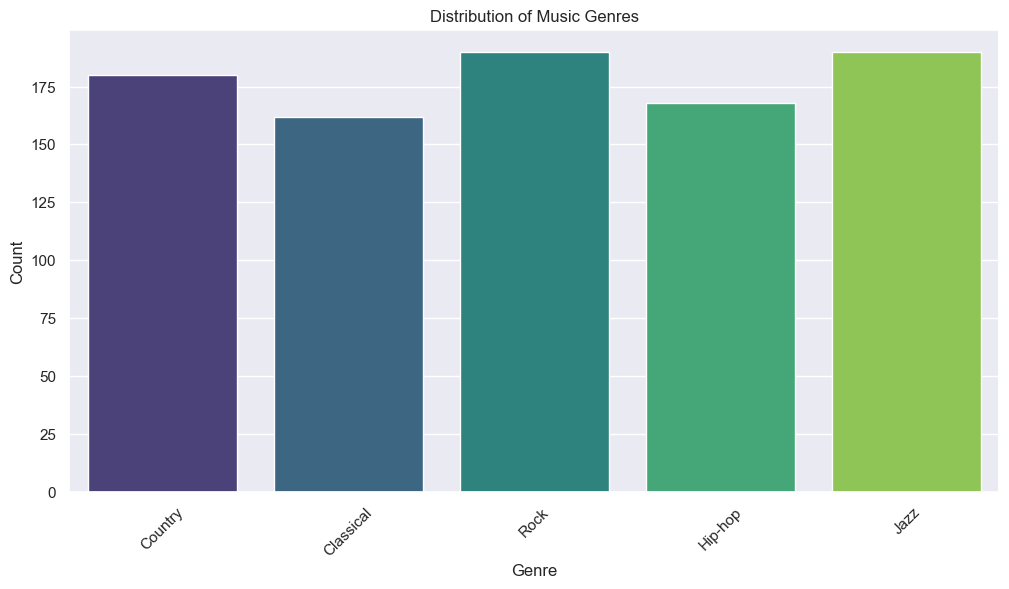

In [3]:
data = pd.read_csv('music_data.csv')

# Create a copy of the DataFrame for analysis
df = data.copy()

# Display the first few rows of the DataFrame to get an initial glance at the data
print(df.head())

# Get an overview of the DataFrame to inspect columns, data types, and non-null counts
print(df.info())

# Check for any missing or null values in the DataFrame
print(df.isnull().sum())

# Investigate the unique music genres in the 'Genre' column
unique_genres = df['Genre'].unique()
print(f"Unique genres: {unique_genres}")
print(f"Number of unique genres: {len(unique_genres)}")

# Visualize the distribution of the 'Genre' column
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Genre', palette="viridis")
plt.title('Distribution of Music Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

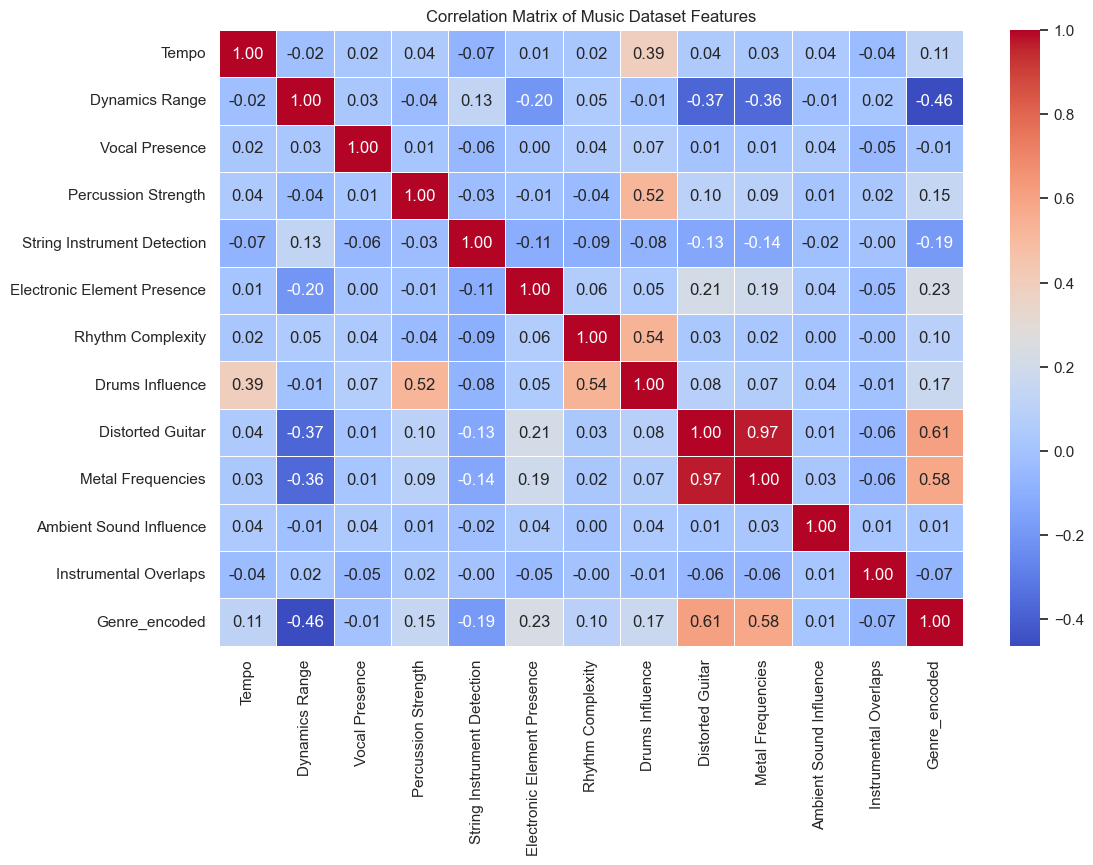

In [4]:
df_cleaned = df.dropna(subset=['Genre']).copy()

# Step 2: Split Data into features (X) and target (y)
X = df_cleaned.drop('Genre', axis=1)
y = df_cleaned['Genre']

# Step 3: Encode the Target (Genre) column
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: Update DataFrame - Create a new DataFrame with the encoded Genre column
X['Genre_encoded'] = y_encoded

# Step 5: Merge X and y_encoded into a single DataFrame for correlation analysis
df_corr = X.copy()

# Step 6: Generate the Correlation Matrix
correlation_matrix = df_corr.corr()

# Step 7: Visualize the Correlation Matrix as a Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Music Dataset Features')
plt.show()

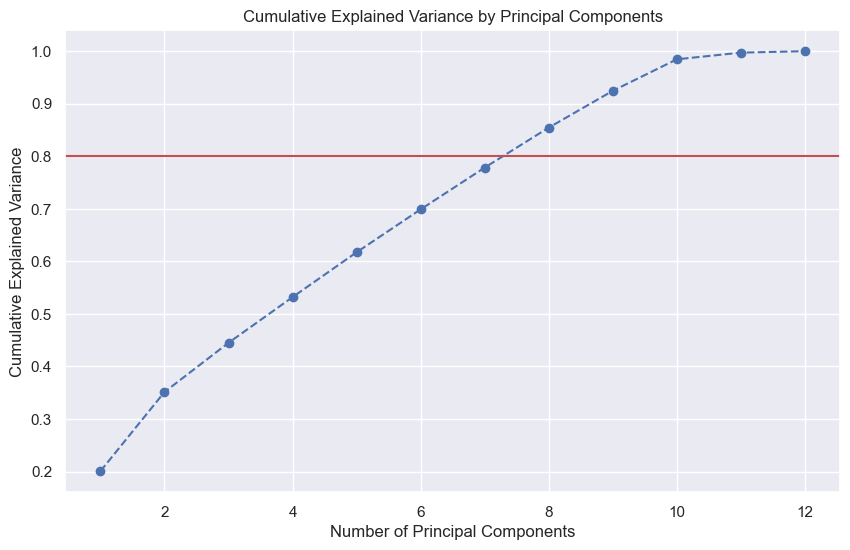

Number of components to retain at least 80% of the variance: 8


In [5]:
# Step 1: Standardize the Data
# We exclude the target variable (Genre_encoded) from scaling as PCA is only applied to the feature set
X_features = df_corr.drop(columns=['Genre_encoded'])  # Only use features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Step 2: Apply PCA without specifying the number of components initially
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Analyze Variance - Obtain explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Visualize Cumulative Variance
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Step 5: Decide on the number of components
# Find the minimum number of components that retain at least 80% of the variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to retain at least 80% of the variance: {n_components_80}")

# Step 6: Reapply PCA with the chosen number of components
pca_optimal = PCA(n_components=n_components_80)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# The transformed data (X_pca_optimal) now has the reduced number of dimensions.

In [6]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_optimal, y_encoded, test_size=0.3, random_state=42
)

# Step 2: Train the Classifier on PCA Data
# Initialize Logistic Regression with a high maximum number of iterations
log_reg_pca = LogisticRegression(max_iter=10000, random_state=42)
log_reg_pca.fit(X_train_pca, y_train_pca)

# Step 3: Model Prediction and Evaluation for PCA Data
# Predict and evaluate the model on PCA-transformed test data
y_pred_pca = log_reg_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
classification_report_pca = classification_report(y_test_pca, y_pred_pca)

print("Accuracy on PCA-transformed data:", accuracy_pca)
print("Classification Report for PCA-transformed data:\n", classification_report_pca)

# Step 4: Repeat for Original Data
# Split the original standardized data (X_scaled) without PCA and encoded target variable (y_encoded)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

# Train the Logistic Regression classifier on the original data
log_reg_orig = LogisticRegression(max_iter=10000, random_state=42)
log_reg_orig.fit(X_train_orig, y_train_orig)

# Predict and evaluate the model on the original test data
y_pred_orig = log_reg_orig.predict(X_test_orig)
accuracy_orig = accuracy_score(y_test_orig, y_pred_orig)
classification_report_orig = classification_report(y_test_orig, y_pred_orig)

print("Accuracy on original data:", accuracy_orig)
print("Classification Report for original data:\n", classification_report_orig)

# Step 5: Compare Performances
print("\nComparison Summary:")
print(f"Accuracy on PCA-transformed data: {accuracy_pca:.4f}")
print(f"Accuracy on original data: {accuracy_orig:.4f}")

# Displaying a brief summary of performance comparison
if accuracy_pca > accuracy_orig:
    print("The PCA-transformed data yielded better accuracy.")
elif accuracy_pca < accuracy_orig:
    print("The original data yielded better accuracy.")
else:
    print("Both methods yielded the same accuracy.")

Accuracy on PCA-transformed data: 0.5355805243445693
Classification Report for PCA-transformed data:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        51
           1       0.32      0.23      0.27        52
           2       0.49      0.44      0.46        48
           3       0.41      0.42      0.42        62
           4       0.51      0.63      0.56        54

    accuracy                           0.54       267
   macro avg       0.52      0.54      0.53       267
weighted avg       0.52      0.54      0.52       267

Accuracy on original data: 0.5318352059925093
Classification Report for original data:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        51
           1       0.33      0.25      0.29        52
           2       0.45      0.46      0.45        48
           3       0.44      0.39      0.41        62
           4       0.49      0.59      0.54       

In [7]:
unknown_genres_df = df[df['Genre'].isnull()].copy()
known_genres_df = df.dropna(subset=['Genre']).copy()

# Prepare the Label Encoder based on the existing target data
label_encoder = LabelEncoder()
y_encoded_known = label_encoder.fit_transform(known_genres_df['Genre'])

# Step 2: Prepare Data for Prediction
# Scale features in both the unknown and known datasets
scaler = StandardScaler()
X_known_scaled = scaler.fit_transform(known_genres_df.drop(columns=['Genre']))
X_unknown_scaled = scaler.transform(unknown_genres_df.drop(columns=['Genre']))

# Check if PCA was effective; if so, apply it to the unknown dataset
# (Suppose we found PCA-based Logistic Regression to perform better in the previous task)
use_pca = True  # Set based on previous model performance
if use_pca:
    # Initialize PCA with optimal components based on previous task
    pca = PCA(n_components=n_components_80)
    X_known_transformed = pca.fit_transform(X_known_scaled)
    X_unknown_transformed = pca.transform(X_unknown_scaled)
else:
    # Use original scaled features
    X_known_transformed = X_known_scaled
    X_unknown_transformed = X_unknown_scaled

# Step 3: Apply the Model for Prediction
# Train the Logistic Regression model on the known data
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_known_transformed, y_encoded_known)

# Predict the genres for the unknown data
y_pred_unknown = model.predict(X_unknown_transformed)

# Step 4: Transform Predictions to Original Labels
# Convert numeric predictions back to genre labels
predicted_genres = label_encoder.inverse_transform(y_pred_unknown)

# Step 5: Update the Original DataFrame
# Assign the predicted genre labels to the missing rows in the original DataFrame
df.loc[df['Genre'].isnull(), 'Genre'] = predicted_genres

# Step 6: Review the Updated Data
print("Updated DataFrame with filled Genre column:")
print(df.info())  # Check that no missing values remain in the 'Genre' column
print(df['Genre'].isnull().sum())  # Verify there are no more nulls in 'Genre'
print(df.head())

Updated DataFrame with filled Genre column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Tempo                        1000 non-null   float64
 1   Dynamics Range               1000 non-null   float64
 2   Vocal Presence               1000 non-null   float64
 3   Percussion Strength          1000 non-null   float64
 4   String Instrument Detection  1000 non-null   float64
 5   Electronic Element Presence  1000 non-null   float64
 6   Rhythm Complexity            1000 non-null   float64
 7   Drums Influence              1000 non-null   float64
 8   Distorted Guitar             1000 non-null   float64
 9   Metal Frequencies            1000 non-null   float64
 10  Ambient Sound Influence      1000 non-null   float64
 11  Instrumental Overlaps        1000 non-null   float64
 12  Genre                        1000